In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

print(f"Train Shape: {train_df.shape}")
print(f"Test Shape: {test_df.shape}")

# Check for nulls
print("\nMissing Values (Train):")
print(train_df.isnull().sum())

# Drop nulls if any (standard hygiene)
train_df = train_df.dropna(subset=['text', 'label'])

# Preview
display(train_df.head())

Train Shape: (9245, 3)
Test Shape: (1028, 2)

Missing Values (Train):
label    0
text     0
id       0
dtype: int64


,label,text,id
0,Sport,21-Jähriger fällt wohl bis Saisonende aus. Wie...,b5e99883a83f420793048898c8a41152
1,Kultur,"Erfundene Bilder zu Filmen, die als verloren g...",fc069d9fc54647ab94f56ccf01851c15
2,Web,Der frischgekürte CEO Sundar Pichai setzt auf ...,91c992a510f94058bc4b417cbe89872b
3,Wirtschaft,"Putin: ""Einigung, dass wir Menge auf Niveau vo...",9b75bafdb2d640708182ded42b08e8fd
4,Inland,Estland sieht den künftigen österreichischen P...,05cf5e5ccb3f4ba69987caa492a17aed



Class Distribution:
label
Panorama         16.333153
Web              16.322336
International    14.710654
Wirtschaft       13.737155
Sport            11.692807
Inland            9.875608
Etat              6.500811
Wissenschaft      5.581395
Kultur            5.246079
Name: proportion, dtype: float64


/tmp/ipykernel_24886/1130244778.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


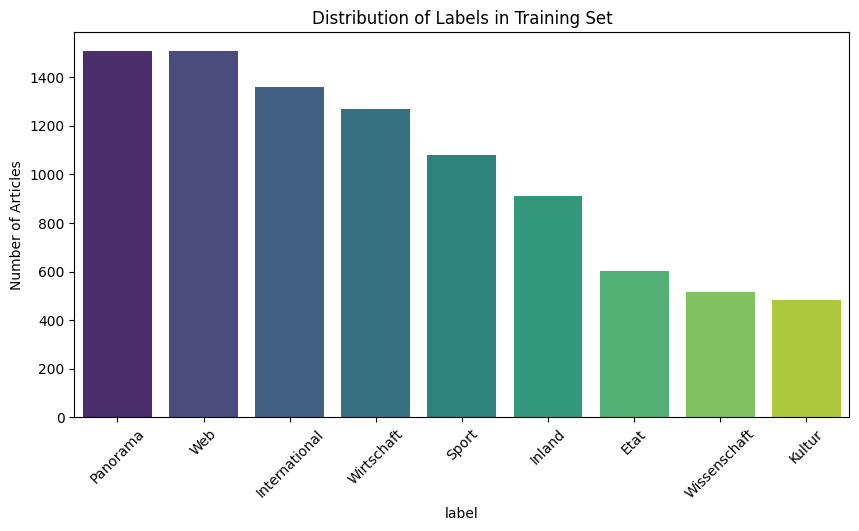

In [2]:
# Calculate counts and percentages
label_counts = train_df['label'].value_counts()
label_percent = train_df['label'].value_counts(normalize=True) * 100

print("\nClass Distribution:")
print(label_percent)

# Visualize
plt.figure(figsize=(10, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribution of Labels in Training Set')
plt.xticks(rotation=45)
plt.ylabel('Number of Articles')
plt.show()


Average Word Count: 363.18
Max Word Count: 3063


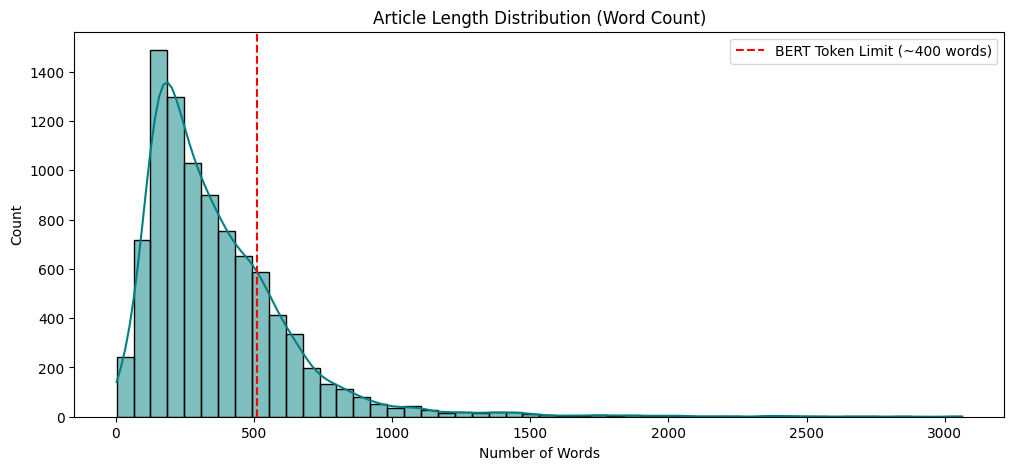

In [3]:
# Calculate word counts
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))

print(f"\nAverage Word Count: {train_df['word_count'].mean():.2f}")
print(f"Max Word Count: {train_df['word_count'].max()}")

# Histogram of lengths
plt.figure(figsize=(12, 5))
sns.histplot(train_df['word_count'], bins=50, kde=True, color='teal')
plt.axvline(x=512, color='red', linestyle='--', label='BERT Token Limit (~400 words)')
plt.title('Article Length Distribution (Word Count)')
plt.xlabel('Number of Words')
plt.legend()
plt.show()


Average Word Count: 368.27
Max Word Count: 4800


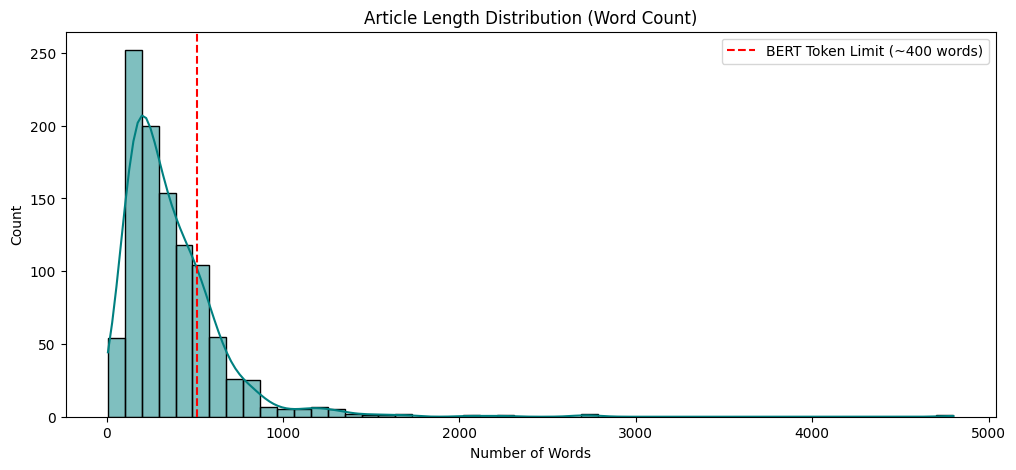

In [4]:
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

print(f"\nAverage Word Count: {test_df['word_count'].mean():.2f}")
print(f"Max Word Count: {test_df['word_count'].max()}")

plt.figure(figsize=(12, 5))
sns.histplot(test_df['word_count'], bins=50, kde=True, color='teal')
plt.axvline(x=512, color='red', linestyle='--', label='BERT Token Limit (~400 words)')
plt.title('Article Length Distribution (Word Count)')
plt.xlabel('Number of Words')
plt.legend()
plt.show()

In [5]:
duplicates = train_df.duplicated(subset=['text']).sum()
print(f"Duplicate articles found: {duplicates}")

# train_df[train_df['text'] == "Der Volltext dieses auf Agenturmeldungen basierenden Artikels steht aus rechtlichen Gründen nicht mehr zur Verfügung."]
if duplicates > 0:
    print("Removing duplicates...")
    train_df = train_df.drop_duplicates(subset=['text'])
    print(f"New Train Shape: {train_df.shape}")

Duplicate articles found: 1
Removing duplicates...
New Train Shape: (9244, 4)


In [1]:
import sys
import os
import torch
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath('.'))

from src.data import DataHandler
from src.custom import GermanClassifier, get_tokenizer
from src.trainer import run_training, generate_submission

# Constants
MODEL_NAME = "deepset/gelectra-large"
MODEL_NAME = "deepset/gbert-large"
MODEL_NAME = "xlm-roberta-large"
MODEL_NAME = "deepset/gbert-base"
MAX_LEN = 512
BATCH_SIZE = 16
EPOCHS = 4
LEARNING_RATE = 4e-6
SEED = 112
DROPOUT_RATE = 0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRACKING_URI = "sqlite:///mlflow.db"
EXPERIMENT_NAME = "German_News_Classification_PyTorch"
SAVE_DIR = "saved_models"

os.makedirs(SAVE_DIR, exist_ok=True)

print("Modules imported successfully.")
print(f"Device: {DEVICE}")

/home/oleksandr/ind2_text-classification/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Modules imported successfully.
Device: cuda


In [2]:
# Initialize Tokenizer
tokenizer = get_tokenizer(MODEL_NAME)

# Initialize DataHandler
handler = DataHandler(
    train_path="data/train.csv",
    test_path="data/test.csv",
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    seed=SEED,
)

# Get DataLoaders
train_loader, val_loader, class_weights = handler.get_dataloaders(batch_size=BATCH_SIZE)

print(f"Classes: {len(handler.id_to_label)}")
print("Data ready for training.")

Classes: 9
Data ready for training.


In [3]:
# Initialize Model
model = GermanClassifier(
    model_name=MODEL_NAME,
    num_labels=len(handler.id_to_label),
    class_weights=class_weights,
    dropout_rate=DROPOUT_RATE
)

2025-12-11 21:25:48.237182: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 21:25:48.299113: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 21:25:49.270062: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Some weights of BertForSequenceClassification were not initialized f

In [4]:
def check_freeze_status(model):
    print("--- Model Freeze Status ---")

    for name, param in model.named_parameters():
            status = "TRAINABLE" if param.requires_grad else "FROZEN"
            print(f"{status}: {name}")
    print("---------------------------")

In [5]:
for param in model.backbone.base_model.parameters():
    param.requires_grad = False

# 3. Ensure the Classifier Head is Unfrozen (Trainable)
# The head is typically named 'classifier' in HF models
for param in model.backbone.classifier.parameters():
    param.requires_grad = True

# 4. Verify
check_freeze_status(model)

--- Model Freeze Status ---
FROZEN: backbone.roberta.embeddings.word_embeddings.weight
FROZEN: backbone.roberta.embeddings.position_embeddings.weight
FROZEN: backbone.roberta.embeddings.token_type_embeddings.weight
FROZEN: backbone.roberta.embeddings.LayerNorm.weight
FROZEN: backbone.roberta.embeddings.LayerNorm.bias
FROZEN: backbone.roberta.encoder.layer.0.attention.self.query.weight
FROZEN: backbone.roberta.encoder.layer.0.attention.self.query.bias
FROZEN: backbone.roberta.encoder.layer.0.attention.self.key.weight
FROZEN: backbone.roberta.encoder.layer.0.attention.self.key.bias
FROZEN: backbone.roberta.encoder.layer.0.attention.self.value.weight
FROZEN: backbone.roberta.encoder.layer.0.attention.self.value.bias
FROZEN: backbone.roberta.encoder.layer.0.attention.output.dense.weight
FROZEN: backbone.roberta.encoder.layer.0.attention.output.dense.bias
FROZEN: backbone.roberta.encoder.layer.0.attention.output.LayerNorm.weight
FROZEN: backbone.roberta.encoder.layer.0.attention.output.Laye

In [6]:
check_freeze_status(model)

--- Model Freeze Status ---
FROZEN: backbone.roberta.embeddings.word_embeddings.weight
FROZEN: backbone.roberta.embeddings.position_embeddings.weight
FROZEN: backbone.roberta.embeddings.token_type_embeddings.weight
FROZEN: backbone.roberta.embeddings.LayerNorm.weight
FROZEN: backbone.roberta.embeddings.LayerNorm.bias
FROZEN: backbone.roberta.encoder.layer.0.attention.self.query.weight
FROZEN: backbone.roberta.encoder.layer.0.attention.self.query.bias
FROZEN: backbone.roberta.encoder.layer.0.attention.self.key.weight
FROZEN: backbone.roberta.encoder.layer.0.attention.self.key.bias
FROZEN: backbone.roberta.encoder.layer.0.attention.self.value.weight
FROZEN: backbone.roberta.encoder.layer.0.attention.self.value.bias
FROZEN: backbone.roberta.encoder.layer.0.attention.output.dense.weight
FROZEN: backbone.roberta.encoder.layer.0.attention.output.dense.bias
FROZEN: backbone.roberta.encoder.layer.0.attention.output.LayerNorm.weight
FROZEN: backbone.roberta.encoder.layer.0.attention.output.Laye

In [7]:
import torch.nn as nn

def unfreeze_by_percentage(model, percentage=0.5):
    # 1. Freeze Everything First
    for param in model.parameters():
        param.requires_grad = False
        
    # 2. Auto-Detect Number of Layers by scanning names
    # We look for the highest number inside names like "layer.11" or "block.23"
    max_layer_index = 0
    for name, _ in model.named_parameters():
        # Split name by dots and look for integers
        parts = name.split('.')
        for part in parts:
            if part.isdigit():
                num = int(part)
                # Sanity check: layers usually aren't numbered > 1000
                if num > max_layer_index and num < 1000: 
                    max_layer_index = num
    
    # Total layers is index + 1 (e.g., if max index is 11, we have 12 layers)
    total_layers = max_layer_index + 1
    
    # 3. Calculate how many to unfreeze
    n_to_unfreeze = int(total_layers * percentage)
    
    # Calculate the starting index (e.g., 12 - 6 = 6. So unfreeze 6,7,8,9,10,11)
    start_layer = total_layers - n_to_unfreeze
    
    print(f"Detected {total_layers} layers. Unfreezing top {n_to_unfreeze} (Layers {start_layer}-{total_layers-1})...")

    # 4. Unfreeze
    for name, param in model.named_parameters():
        # A. Unfreeze layers >= start_layer
        # We check every number in the name again
        is_target_layer = False
        parts = name.split('.')
        for part in parts:
            if part.isdigit():
                if int(part) >= start_layer:
                    is_target_layer = True
        
        if is_target_layer:
            param.requires_grad = True
            
        # B. ALWAYS unfreeze the Classifier / Head
        # Common names for the final layer
        if any(keyword in name for keyword in ["classifier", "head", "score", "pooler", "linear"]):
            param.requires_grad = True
            
    print("Done.")

# --- Usage ---
# Works even if 'model' is your custom wrapper
# unfreeze_by_percentage(model, percentage=0.5)

In [8]:
unfreeze_by_percentage(model, percentage=0.25)

Detected 24 layers. Unfreezing top 6 (Layers 18-23)...
Done.


In [ ]:
def reinit_top_layers(model, num_layers=3):

    hf_model = getattr(model, "backbone", model)

    if hasattr(hf_model, "bert"):
        encoder = hf_model.bert.encoder
    elif hasattr(hf_model, "roberta"):          
        encoder = hf_model.roberta.encoder
    elif hasattr(hf_model, "electra"):
        encoder = hf_model.electra.encoder
    else:
        print("Warning: Could not auto-detect encoder. Check model structure.")
        print("HF model class:", type(hf_model))
        return

    layers_to_reset = encoder.layer[-num_layers:]

    for layer in layers_to_reset:
        layer.apply(hf_model._init_weights)

    print(
        f"Successfully re-initialized the top {num_layers} layers "
        f"of {hf_model.config.model_type}."
    )


In [6]:
reinit_top_layers(model, num_layers=1)
model.__dict__

Successfully re-initialized the top 1 layers of bert.


{'training': True,
 '_parameters': {},
 '_buffers': {},
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': {'backbone': BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(31102, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
     

In [7]:
# Run Training

def get_llrd_params(model, peak_lr, classifier_lr, weight_decay=0.01, layer_decay=0.95):
    opt_parameters = []
    
    # 1. Find the Classifier Head (and give it High LR)
    if hasattr(model, "classifier"): head_module = model.classifier
    elif hasattr(model, "head"): head_module = model.head
    else: head_module = None # Fallback

    if head_module:
        head_params = list(head_module.named_parameters())
    else:
        # Fallback: search for params with 'classifier' or 'head' in name
        head_params = [(n, p) for n, p in model.named_parameters() if "classifier" in n or "head" in n]

    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    
    opt_parameters.append({
        "params": [p for n, p in head_params if not any(nd in n for nd in no_decay)],
        "lr": classifier_lr, # <--- HIGH LR
        "weight_decay": weight_decay
    })
    opt_parameters.append({
        "params": [p for n, p in head_params if any(nd in n for nd in no_decay)],
        "lr": classifier_lr, # <--- HIGH LR
        "weight_decay": 0.0
    })

    # 2. Find the Body Layers (and give them Low LR + Decay)
    # Support for XLM-R, BERT, RoBERTa
    if hasattr(model, "roberta"): encoder = model.roberta.encoder; embeddings = model.roberta.embeddings
    elif hasattr(model, "bert"): encoder = model.bert.encoder; embeddings = model.bert.embeddings
    elif hasattr(model, "backbone"): encoder = model.backbone.base_model.encoder; embeddings = model.backbone.base_model.embeddings
    else: encoder = model.base_model.encoder; embeddings = model.base_model.embeddings

    # Loop layers top-to-bottom
    for i, layer in enumerate(reversed(encoder.layer)):
        layer_lr = peak_lr * (layer_decay ** i) # Decay as we go down
        
        opt_parameters.append({
            "params": [p for n, p in layer.named_parameters() if not any(nd in n for nd in no_decay)],
            "lr": layer_lr, 
            "weight_decay": weight_decay
        })
        opt_parameters.append({
            "params": [p for n, p in layer.named_parameters() if any(nd in n for nd in no_decay)],
            "lr": layer_lr, 
            "weight_decay": 0.0
        })

    # 3. Embeddings (Lowest LR)
    embed_lr = peak_lr * (layer_decay ** len(encoder.layer))
    embed_params = list(embeddings.named_parameters())
    
    opt_parameters.append({
        "params": [p for n, p in embed_params if not any(nd in n for nd in no_decay)],
        "lr": embed_lr, 
        "weight_decay": weight_decay
    })
    opt_parameters.append({
        "params": [p for n, p in embed_params if any(nd in n for nd in no_decay)],
        "lr": embed_lr, 
        "weight_decay": 0.0
    })
    
    return opt_parameters

optimizer_grouped_parameters = get_llrd_params(
            model, 
            peak_lr=4e-6,         # BODY: Keep this very low/safe (4e-6)
            classifier_lr=1e-4,   # HEAD: Make this fast (1e-4)
            weight_decay=0.01,
            layer_decay=0.95
        )
optimizer = torch.optim.AdamW(optimizer_grouped_parameters)

best_accuracy = run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device_str=DEVICE,
    learning_rate=LEARNING_RATE,
    epochs=15,
    tracking_uri=TRACKING_URI,
    experiment_name=EXPERIMENT_NAME,
    save_dir=SAVE_DIR,
    optimizer=optimizer,
    run_name="xlm-roberta-large_100_unfrozen_batch_16"
)

print(f"Best Validation Accuracy: {best_accuracy:.4f}")

2025/12/11 21:26:11 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/11 21:26:11 INFO mlflow.store.db.utils: Updating database tables
2025/12/11 21:26:11 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/11 21:26:11 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/11 21:26:11 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/11 21:26:11 INFO alembic.runtime.migration: Will assume non-transactional DDL.
Training:   0%|          | 0/520 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (893 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (784 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this mod

Epoch 1/15 | Train Loss: 1.9347 | Val Acc: 0.7449


Training: 100%|██████████| 520/520 [02:35<00:00,  3.35it/s, loss=0.6016, acc=0.8214]


Epoch 2/15 | Train Loss: 0.6016 | Val Acc: 0.8562


Training: 100%|██████████| 520/520 [02:33<00:00,  3.40it/s, loss=0.3535, acc=0.8746]


Epoch 3/15 | Train Loss: 0.3535 | Val Acc: 0.8811


Training: 100%|██████████| 520/520 [02:34<00:00,  3.37it/s, loss=0.2746, acc=0.9009]


Epoch 4/15 | Train Loss: 0.2746 | Val Acc: 0.8908


Training: 100%|██████████| 520/520 [02:32<00:00,  3.41it/s, loss=0.2289, acc=0.9197]


Epoch 5/15 | Train Loss: 0.2289 | Val Acc: 0.9081


Training: 100%|██████████| 520/520 [02:31<00:00,  3.43it/s, loss=0.1848, acc=0.9367]


Epoch 6/15 | Train Loss: 0.1848 | Val Acc: 0.9049


Training: 100%|██████████| 520/520 [02:32<00:00,  3.41it/s, loss=0.1594, acc=0.9478]


Epoch 7/15 | Train Loss: 0.1594 | Val Acc: 0.9049


Training: 100%|██████████| 520/520 [02:31<00:00,  3.44it/s, loss=0.1385, acc=0.9529]


Epoch 8/15 | Train Loss: 0.1385 | Val Acc: 0.9027


Training: 100%|██████████| 520/520 [02:31<00:00,  3.44it/s, loss=0.1193, acc=0.9605]


Epoch 9/15 | Train Loss: 0.1193 | Val Acc: 0.9049


Training: 100%|██████████| 520/520 [02:34<00:00,  3.38it/s, loss=0.1025, acc=0.9649]


Epoch 10/15 | Train Loss: 0.1025 | Val Acc: 0.9059


Training: 100%|██████████| 520/520 [02:34<00:00,  3.37it/s, loss=0.0936, acc=0.9696]


Epoch 11/15 | Train Loss: 0.0936 | Val Acc: 0.9114


Training:   6%|▋         | 33/520 [00:10<02:41,  3.02it/s, loss=0.0883, acc=0.9735]


KeyboardInterrupt: 

In [15]:
def unfreeze_last_n_layers(model, n=1):
    # 1. Get the list of 12 transformer layers
    # (Hugging Face stores them in .encoder.layer)
    all_params = list(model.parameters())
    print(len(all_params))
# 3. Unfreeze only the last 20
# We slice the list [-20:] to get the last 20 items
    for param in all_params[-n:]:
        param.requires_grad = True

In [ ]:
unfreeze_last_n_layers(model, n=80)

393


In [9]:
check_freeze_status(model)

--- Model Freeze Status ---
FROZEN: backbone.bert.embeddings.word_embeddings.weight
FROZEN: backbone.bert.embeddings.position_embeddings.weight
FROZEN: backbone.bert.embeddings.token_type_embeddings.weight
FROZEN: backbone.bert.embeddings.LayerNorm.weight
FROZEN: backbone.bert.embeddings.LayerNorm.bias
FROZEN: backbone.bert.encoder.layer.0.attention.self.query.weight
FROZEN: backbone.bert.encoder.layer.0.attention.self.query.bias
FROZEN: backbone.bert.encoder.layer.0.attention.self.key.weight
FROZEN: backbone.bert.encoder.layer.0.attention.self.key.bias
FROZEN: backbone.bert.encoder.layer.0.attention.self.value.weight
FROZEN: backbone.bert.encoder.layer.0.attention.self.value.bias
FROZEN: backbone.bert.encoder.layer.0.attention.output.dense.weight
FROZEN: backbone.bert.encoder.layer.0.attention.output.dense.bias
FROZEN: backbone.bert.encoder.layer.0.attention.output.LayerNorm.weight
FROZEN: backbone.bert.encoder.layer.0.attention.output.LayerNorm.bias
FROZEN: backbone.bert.encoder.laye

In [12]:
# Run Training
best_accuracy = run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device_str=DEVICE,
    learning_rate=LEARNING_RATE,
    epochs=2,
    tracking_uri=TRACKING_URI,
    experiment_name=EXPERIMENT_NAME,
    save_dir=SAVE_DIR
)

print(f"Best Validation Accuracy: {best_accuracy:.4f}")

Training: 100%|██████████| 260/260 [02:45<00:00,  1.57it/s, loss=0.0615, acc=0.9788]



Epoch 1/2 | Train Loss: 0.0615 | Val Acc: 0.9081


Training: 100%|██████████| 260/260 [02:45<00:00,  1.57it/s, loss=0.0453, acc=0.9858]



Epoch 2/2 | Train Loss: 0.0453 | Val Acc: 0.9027
Best Validation Accuracy: 0.9081


In [8]:
model_path = os.path.join(SAVE_DIR, "best_model_xlm-roberta-large_100_unfrozen_batch_16_0.9114.pth")
if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=torch.device(DEVICE))
    # Filter out criterion to avoid state_dict mismatch
    state_dict = {k: v for k, v in state_dict.items()}#if not k.startswith('criterion')}
    model.load_state_dict(state_dict)
    print(f"Loaded best model from {model_path}")
else:
    print("Model file not found. Please ensure training completed successfully.")

Loaded best model from saved_models/best_model_xlm-roberta-large_100_unfrozen_batch_16_0.9114.pth


In [9]:
test_loader, test_ids = handler.get_test_loader(batch_size=BATCH_SIZE)

submission = generate_submission(
    model=model,
    test_loader=test_loader,
    test_ids=test_ids,
    device_str=DEVICE,
    id_to_label=handler.id_to_label,
    output_path="data/submission_last_gbert-base.csv"
)

print(submission.head())

Generating Submission:   0%|          | 0/65 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1058 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (799 > 512). Running this sequence through the model will result in indexing errors
Generating Submission: 100%|██████████| 65/65 [00:05<00:00, 11.60it/s]

Submission saved to data/submission_last_gbert-base.csv
                                 id          label
0  4ffe04ebd43e4441ab2ac26c1ce57990     Wirtschaft
1  52637894c098414e9bdd1caab65c4349          Sport
2  93f5aa94b3aa49d6bec7677687048b0e            Web
3  8a6e232dd63a4c62a644cfe0a2f787cd          Sport
4  aa2f7d04b1364ab18363e30e7305ae01  International


In [ ]:
from sklearn.metrics import classification_report
from tqdm import tqdm


def evaluate_validation(model, val_loader, device, id_to_label):
    device = torch.device(device)
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation Evaluation"):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids, mask)
            # Handle both dict and object returns
            logits = outputs['logits'] if isinstance(outputs, dict) else outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to string labels
    y_true = [id_to_label[int(l)] for l in all_labels]
    y_pred = [id_to_label[int(p)] for p in all_preds]

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


# Run evaluation on validation set
evaluate_validation(model, val_loader, DEVICE, handler.id_to_label)

Validation Evaluation:   0%|          | 0/58 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (1013 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1013 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (542 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (804 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence leng

In [ ]:
def load_model(path):
    model_path = os.path.join(SAVE_DIR, path)
    if os.path.exists(model_path):
        state_dict = torch.load(model_path, map_location=torch.device(DEVICE))
        # Filter out criterion to avoid state_dict mismatch
        state_dict = {k: v for k, v in state_dict.items() if not k.startswith('criterion')}
        model.load_state_dict(state_dict)
        print(f"Loaded best model from {model_path}")
    else:
        print("Model file not found. Please ensure training completed successfully.")
    return model

In [ ]:
import torch
import torch.nn.functional as F

def predict_proba(model, loader, device):
    model.to(device)
    model.eval()
    all_probs = []

    with torch.no_grad():
        for batch in loader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            outputs = model(input_ids=ids, attention_mask=mask)
            probs = F.softmax(outputs.logits, dim=-1).cpu()
            all_probs.append(probs)

    return torch.cat(all_probs, dim=0)  # [N, num_classes]

# список шляхів до чекпоінтів
paths = [
    "gbert_large_headtail_seed42.pt",
    "gbert_large_headtail_seed43.pt",
    "gbert_large_headtail_seed44.pt",
]

probs_list = []
for path in paths:
    model = load_model(path)  # твоя функція завантаження
    probs = predict_proba(model, test_loader, DEVICE)
    probs_list.append(probs)

ensemble_probs = sum(probs_list) / len(probs_list)
y_pred = ensemble_probs.argmax(dim=1)


# NEW MODEL


In [1]:
import sys
import os
import torch
import pandas as pd
import numpy as np
import random
import mlflow
from tqdm import tqdm
from torch.amp import GradScaler
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

MODEL_NAME = "LennartKeller/longformer-gottbert-base-8192-aw512"
MAX_LEN = 8192


PHYSICAL_BATCH_SIZE = 2  
GRADIENT_ACCUMULATION_STEPS = 16 

EPOCHS = 4
LEARNING_RATE = 2e-5
SEED = 42
DROPOUT_RATE = 0.1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRACKING_URI = "sqlite:///mlflow.db"
EXPERIMENT_NAME = "German_News_Classification"
SAVE_DIR = "saved_models"

os.makedirs(SAVE_DIR, exist_ok=True)

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
print(f"Device: {DEVICE}")
print(f"Effective Batch Size: {PHYSICAL_BATCH_SIZE * GRADIENT_ACCUMULATION_STEPS}")

/home/oleksandr/ind2_text-classification/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda
Effective Batch Size: 32


In [2]:
# Initialize Tokenizer
from src.custom import get_tokenizer
from src.data import DataHandler
tokenizer = get_tokenizer(MODEL_NAME)

handler = DataHandler(
    train_path="data/train.csv",
    test_path="data/test.csv",
    tokenizer=tokenizer,
    max_len=MAX_LEN,
    seed=SEED
)

# 3. Get Loaders & Class Weights
# We pass the small PHYSICAL batch size here (2)
train_loader, val_loader, class_weights = handler.get_dataloaders(batch_size=PHYSICAL_BATCH_SIZE)

print(f"Classes: {len(handler.id_to_label)}")
print(f"Training Batches per Epoch: {len(train_loader)}")
print(f"Padding Token ID: {tokenizer.pad_token_id}")

Classes: 9
Training Batches per Epoch: 4160
Padding Token ID: 1


In [3]:
# Initialize Model
from src.custom import GermanClassifier
model = GermanClassifier(
    model_name=MODEL_NAME,
    num_labels=len(handler.id_to_label),
    class_weights=class_weights, # <--- Fixes Imbalance
    dropout_rate=DROPOUT_RATE
)

model.to(DEVICE)
print("Longformer Model initialized and moved to GPU.")

2025-12-11 00:50:15.872003: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 00:50:15.914318: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 00:50:16.815623: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 00:50:16.815623: I tensorflow/core/util/port.cc:153] oneD

Longformer Model initialized and moved to GPU.


In [ ]:
def check_freeze_status(model):
    print("--- Model Freeze Status ---")
    layers_to_check = [
        # The main body (Encoder)
        "backbone.bert.embeddings.word_embeddings.weight", 
        "backbone.bert.encoder.layer.0.output.dense.weight",
        
        # The Classification Head
        # Note: BERT usually just has 'classifier.weight' and 'classifier.bias'
        "backbone.classifier.weight", 
        "backbone.classifier.bias"
    ]
    
    for name, param in model.named_parameters():
        if name in layers_to_check:
            status = "TRAINABLE" if param.requires_grad else "FROZEN"
            print(f"{status}: {name}")
    print("---------------------------")

In [ ]:
for param in model.backbone.base_model.parameters():
    param.requires_grad = False

# 3. Ensure the Classifier Head is Unfrozen (Trainable)
# The head is typically named 'classifier' in HF models
for param in model.backbone.classifier.parameters():
    param.requires_grad = True

# 4. Verify
check_freeze_status(model)

In [4]:
import torch.optim as optim

optimizer_parameters = [
    {
        # Group 1: The Longformer Body (Slow learning to preserve knowledge)
        "params": model.backbone.base_model.parameters(), 
        "lr": 1e-5
    },
    {
        # Group 2: The Classifier Head (Fast learning for new classes)
        "params": model.backbone.classifier.parameters(), 
        "lr": 1e-3
    }
]

optimizer = optim.AdamW(optimizer_parameters)
print("Optimizer created with Two-Group Learning Rates.")

Optimizer created with Two-Group Learning Rates.


In [5]:
# Run Training
from src.trainer import run_training
best_accuracy = run_training(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device_str=DEVICE,
    epochs=EPOCHS,
    
    tracking_uri=TRACKING_URI,
    experiment_name=EXPERIMENT_NAME,
    save_dir=SAVE_DIR,
    
    optimizer=optimizer, 
    accumulation_steps=GRADIENT_ACCUMULATION_STEPS
)

print(f"\nTraining Complete. Best Validation Accuracy: {best_accuracy:.4f}")

2025/12/11 00:50:20 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/11 00:50:20 INFO mlflow.store.db.utils: Updating database tables
2025/12/11 00:50:20 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/11 00:50:20 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/11 00:50:20 INFO mlflow.store.db.utils: Updating database tables
2025/12/11 00:50:20 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/11 00:50:20 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/11 00:50:21 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/11 00:50:21 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/11 00:50:21 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/11 00:50:21 INFO alembic.runtime.migration: Will assume non-transactional DDL.
Training:   0%|          | 0/4160 [00:00<?, ?it/s]Input ids are automatically padded to be a multiple of `c

Epoch 1/4 | Train Loss: 0.7629 | Val Acc: 0.8551


Training: 100%|██████████| 4160/4160 [43:23<00:00,  1.60it/s, loss=0.3355, acc=0.8858]  



Epoch 2/4 | Train Loss: 0.3355 | Val Acc: 0.8865


Training: 100%|██████████| 4160/4160 [40:34<00:00,  1.71it/s, loss=0.2132, acc=0.9284]  



Epoch 3/4 | Train Loss: 0.2132 | Val Acc: 0.8919


Training: 100%|██████████| 4160/4160 [40:17<00:00,  1.72it/s, loss=0.1417, acc=0.9508]  



Epoch 4/4 | Train Loss: 0.1417 | Val Acc: 0.9038

Training Complete. Best Validation Accuracy: 0.9038

Training Complete. Best Validation Accuracy: 0.9038


In [ ]:
def unfreeze_last_n_layers(model, n=1):
    # 1. Get the list of 12 transformer layers
    # (Hugging Face stores them in .encoder.layer)
    encoder_layers = model.backbone.base_model.encoder.layer
    
    # 2. Calculate which layer to start from
    # If n=1, we start at 12-1 = 11. If n=2, we start at 10, etc.
    start_index = len(encoder_layers) - n
    
    print(f"Unfreezing the last {n} layers (Layers {start_index} to 11)...")
    
    # 3. Loop through just those layers and unfreeze them
    for i in range(start_index, len(encoder_layers)):
        for param in encoder_layers[i].parameters():
            param.requires_grad = True

In [ ]:
model_path = os.path.join(SAVE_DIR, "best_model_longform.pth")
if os.path.exists(model_path):
    state_dict = torch.load(model_path, map_location=torch.device(DEVICE))
    # Filter out criterion to avoid state_dict mismatch
    state_dict = {k: v for k, v in state_dict.items() if not k.startswith('criterion')}
    model.load_state_dict(state_dict)
    print(f"Loaded best model from {model_path}")
else:
    print("Model file not found. Please ensure training completed successfully.")

Model file not found. Please ensure training completed successfully.


In [7]:
test_loader, test_ids = handler.get_test_loader(batch_size=2)

submission = generate_submission(
    model=model,
    test_loader=test_loader,
    test_ids=test_ids,
    device_str=DEVICE,
    id_to_label=handler.id_to_label,
    output_path="data/submission_with_longform.csv"
)

print(submission.head())

NameError: name 'generate_submission' is not defined

In [11]:
from sklearn.metrics import classification_report
from tqdm import tqdm


def evaluate_validation(model, val_loader, device, id_to_label):
    device = torch.device(device)
    model.to(device)
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation Evaluation"):
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(ids, mask)
            # Handle both dict and object returns
            logits = outputs['logits'] if isinstance(outputs, dict) else outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert to string labels
    y_true = [id_to_label[int(l)] for l in all_labels]
    y_pred = [id_to_label[int(p)] for p in all_preds]

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


# Run evaluation on validation set
evaluate_validation(model, val_loader, DEVICE, handler.id_to_label)

Validation Evaluation: 100%|██████████| 58/58 [00:28<00:00,  2.06it/s]


Classification Report:
               precision    recall  f1-score   support

         Etat       0.93      0.88      0.91        60
       Inland       0.88      0.78      0.83        91
International       0.92      0.91      0.92       136
       Kultur       0.88      0.92      0.90        49
     Panorama       0.85      0.87      0.86       151
        Sport       0.98      0.99      0.99       108
          Web       0.97      0.97      0.97       151
   Wirtschaft       0.88      0.92      0.90       127
 Wissenschaft       0.89      0.92      0.91        52

     accuracy                           0.91       925
    macro avg       0.91      0.91      0.91       925
 weighted avg       0.91      0.91      0.91       925



In [1]:
# Cell 1
from src.config import Config
import os

# Create handler once to get consistent id_to_label mapping
from src.custom import get_tokenizer
from src.data import DataHandler

dummy_tokenizer = get_tokenizer("deepset/gbert-large")
dummy_handler = DataHandler(
    train_path='data/train.csv',
    test_path='data/test.csv',
    tokenizer=dummy_tokenizer,
    max_len=512,
    seed=42,
)
_ , _, _ = dummy_handler.get_dataloaders(batch_size=16)
GLOBAL_ID_TO_LABEL = dummy_handler.id_to_label
print(f"Global ID-to-Label mapping: {GLOBAL_ID_TO_LABEL}")

# Top-performing checkpoints that exist
ENSEMBLE_MODELS = [
    # (huggingface_model_name, checkpoint_path)
    ("deepset/gbert-large", "saved_models/best_model_gBERT-large_100_0.9168.pth"),
    ("deepset/gbert-large", "saved_models/best_model_deepset_gbert-large_0_layers_unfrozen_0.9135.pth"),
    ("deepset/gbert-large", "saved_models/best_model_deepset_gbert-large_100_unfrozen_0.9124.pth"),
    ("xlm-roberta-large",   "saved_models/best_model_xlm-roberta-large_100_unfrozen_batch_16_0.9103.pth"),
]

print(f"\nEnsemble config: {len(ENSEMBLE_MODELS)} models")
for model_name, ckpt_path in ENSEMBLE_MODELS:
    exists = "✓" if os.path.exists(ckpt_path) else "✗"
    print(f"  {exists} {ckpt_path}")


/home/oleksandr/ind2_text-classification/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Global ID-to-Label mapping: {0: 'Etat', 1: 'Inland', 2: 'International', 3: 'Kultur', 4: 'Panorama', 5: 'Sport', 6: 'Web', 7: 'Wirtschaft', 8: 'Wissenschaft'}

Ensemble config: 4 models
  ✓ saved_models/best_model_gBERT-large_100_0.9168.pth
  ✓ saved_models/best_model_deepset_gbert-large_0_layers_unfrozen_0.9135.pth
  ✓ saved_models/best_model_deepset_gbert-large_100_unfrozen_0.9124.pth
  ✓ saved_models/best_model_xlm-roberta-large_100_unfrozen_batch_16_0.9103.pth


In [2]:
# Cell 2
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd

from src.custom import GermanClassifier, get_tokenizer
from src.data import DataHandler

DEVICE = torch.device(Config.DEVICE)

def load_classifier(model_name: str, ckpt_path: str, num_labels: int) -> GermanClassifier:
    model = GermanClassifier(
        model_name=model_name,
        num_labels=num_labels,
        class_weights=None,
        dropout_rate=Config.DROPOUT_RATE,
    )
    state = torch.load(ckpt_path, map_location="cpu")
    # Filter out criterion to avoid state_dict mismatch
    state = {k: v for k, v in state.items() if not k.startswith('criterion')}
    model.load_state_dict(state)
    model.to(DEVICE)
    model.eval()
    return model

def predict_proba_single(model_name: str, ckpt_path: str, batch_size: int = 16):
    """
    Рахує ймовірності [N, num_classes] на тесті для ОДНІЄЇ моделі.
    Повертає (probs, test_ids, id_to_label).
    """
    tokenizer = get_tokenizer(model_name)

    handler = DataHandler(
        train_path='data/train.csv',
        test_path='data/test.csv',
        tokenizer=tokenizer,
        max_len=512,
        seed=42,
    )

    test_loader, test_ids = handler.get_test_loader(batch_size=batch_size)
    num_labels = 9
    model = load_classifier(model_name, ckpt_path, num_labels)

    all_probs = []

    with torch.no_grad():
        for batch in test_loader:
            ids = batch["input_ids"].to(DEVICE, non_blocking=True)
            mask = batch["attention_mask"].to(DEVICE, non_blocking=True)

            outputs = model(ids, mask)          # labels не передаємо
            logits = outputs["logits"]
            probs = F.softmax(logits, dim=-1).cpu()
            all_probs.append(probs)

    probs = torch.cat(all_probs, dim=0).numpy()   # [N, num_classes]
    
    # Handle case where test_ids might be None; load from CSV
    if test_ids is None:
        test_df = pd.read_csv('data/test.csv')
        test_ids = test_df['id'].tolist()
    
    # Return probs, test_ids, and GLOBAL mapping
    return probs, test_ids, GLOBAL_ID_TO_LABEL


In [3]:
# Cell 3

all_probs = []
ids_ref = None
id_to_label_ref = None

for model_name, ckpt_path in ENSEMBLE_MODELS:
    print(f"\nRunning model: {model_name} | {ckpt_path}")
    try:
        probs, test_ids, id_to_label = predict_proba_single(model_name, ckpt_path, batch_size=16)
        print(f"  Probs shape: {probs.shape}")
        print(f"  Test IDs count: {len(test_ids)}")
        print(f"  Classes: {len(id_to_label)}")

        if ids_ref is None:
            ids_ref = test_ids
            id_to_label_ref = id_to_label
            print(f"  Set reference mapping with {len(id_to_label_ref)} classes")
        else:
            # Перевіряємо, що порядок id однаковий
            assert test_ids == ids_ref, "Test ids order mismatch between models!"
            print(f"  IDs match reference")

        all_probs.append(probs)
        print(f"  ✓ Model added to ensemble (total: {len(all_probs)})")
    except Exception as e:
        print(f"  ✗ Error loading model: {e}")
        continue

# Check if we have any probabilities
if not all_probs:
    print("\n⚠️  No models were successfully loaded. Check file paths and try again.")
else:
    print(f"\n✓ Successfully loaded {len(all_probs)} models")
    
    # усереднюємо
    ensemble_probs = sum(all_probs) / len(all_probs)        # [N, num_classes]
    pred_ids = ensemble_probs.argmax(axis=1)                # [N]
    
    if id_to_label_ref is None:
        print("⚠️  id_to_label_ref is still None. Check data loading.")
    else:
        pred_labels = [id_to_label_ref[int(i)] for i in pred_ids]
        print(f"✓ Generated {len(pred_labels)} predictions")



Running model: deepset/gbert-large | saved_models/best_model_gBERT-large_100_0.9168.pth


2025-12-11 21:15:59.971070: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-11 21:16:00.003121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-11 21:16:01.048264: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Some weights of BertForSequenceClassification were not initialized f

  Probs shape: (1028, 9)
  Test IDs count: 1028
  Classes: 9
  Set reference mapping with 9 classes
  ✓ Model added to ensemble (total: 1)

Running model: deepset/gbert-large | saved_models/best_model_deepset_gbert-large_0_layers_unfrozen_0.9135.pth


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1058 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (799 > 512). Running this sequence through the model will r

  Probs shape: (1028, 9)
  Test IDs count: 1028
  Classes: 9
  IDs match reference
  ✓ Model added to ensemble (total: 2)

Running model: deepset/gbert-large | saved_models/best_model_deepset_gbert-large_100_unfrozen_0.9124.pth


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at deepset/gbert-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1058 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (799 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1043 > 512). Running this sequence through the model will r

  Probs shape: (1028, 9)
  Test IDs count: 1028
  Classes: 9
  IDs match reference
  ✓ Model added to ensemble (total: 3)

Running model: xlm-roberta-large | saved_models/best_model_xlm-roberta-large_100_unfrozen_batch_16_0.9103.pth


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Token indices sequence length is longer than the specified maximum sequence length for this model (688 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (851 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1125 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length f

  Probs shape: (1028, 9)
  Test IDs count: 1028
  Classes: 9
  IDs match reference
  ✓ Model added to ensemble (total: 4)

✓ Successfully loaded 4 models
✓ Generated 1028 predictions


In [4]:
# Cell 4

submission = pd.DataFrame({
    "id": ids_ref,
    "label": pred_labels,
})

submission_path = os.path.join("data", "submission_ensemble.csv")
submission.to_csv(submission_path, index=False)
print(f"Submission saved to {submission_path}")
submission.head()


Submission saved to data/submission_ensemble.csv


,id,label
0,4ffe04ebd43e4441ab2ac26c1ce57990,Wirtschaft
1,52637894c098414e9bdd1caab65c4349,Sport
2,93f5aa94b3aa49d6bec7677687048b0e,Web
3,8a6e232dd63a4c62a644cfe0a2f787cd,Sport
4,aa2f7d04b1364ab18363e30e7305ae01,International
